### Problem statement: predicting turbine energy yield (TEY) using ambient variables as features.

### The dataset contains 36733 instances of 11 sensor measures aggregated over one hour (by means of average or sum) from a gas turbine. 
### The Dataset includes gas turbine parameters (such as Turbine Inlet Temperature and Compressor Discharge pressure) in addition to the ambient variables.

### Attribute Information:

### The explanations of sensor measurements and their brief statistics are given below.

#### Variable (Abbr.) Unit Min Max Mean
#### Ambient temperature (AT) C â€“6.23 37.10 17.71
#### Ambient pressure (AP) mbar 985.85 1036.56 1013.07
#### Ambient humidity (AH) (%) 24.08 100.20 77.87
#### Air filter difference pressure (AFDP) mbar 2.09 7.61 3.93
#### Gas turbine exhaust pressure (GTEP) mbar 17.70 40.72 25.56
#### Turbine inlet temperature (TIT) C 1000.85 1100.89 1081.43
#### Turbine after temperature (TAT) C 511.04 550.61 546.16
#### Compressor discharge pressure (CDP) mbar 9.85 15.16 12.06
#### Turbine energy yield (TEY) MWH 100.02 179.50 133.51
#### Carbon monoxide (CO) mg/m3 0.00 44.10 2.37
#### Nitrogen oxides (NOx) mg/m3 25.90 119.91 65.29

--------------
----------
### Import Libraries


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import scale,StandardScaler
from sklearn.metrics import classification_report, accuracy_score

from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,InputLayer
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf

### Import Data

In [3]:
gas_turbines = pd.read_csv("gas_turbines.csv")
gas_turbines = gas_turbines.iloc[:,[7,0,1,2]]

In [4]:
gas_turbines.head()

,TEY,AT,AP,AH
0,114.70,6.8594,1007.9,96.799
1,114.72,6.7850,1008.4,97.118
2,114.71,6.8977,1008.8,95.939
3,114.72,7.0569,1009.2,95.249
4,114.72,7.3978,1009.7,95.150


In [5]:
gas_turbines.tail()

,TEY,AT,AP,AH
15034,111.61,9.0301,1005.6,98.460
15035,111.78,7.8879,1005.9,99.093
15036,110.19,7.2647,1006.3,99.496
15037,110.74,7.0060,1006.8,99.008
15038,111.58,6.9279,1007.2,97.533


### Data Understanding

In [6]:
gas_turbines.shape

(15039, 4)

In [7]:
gas_turbines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TEY     15039 non-null  float64
 1   AT      15039 non-null  float64
 2   AP      15039 non-null  float64
 3   AH      15039 non-null  float64
dtypes: float64(4)
memory usage: 470.1 KB


In [8]:
gas_turbines.duplicated().sum()

0

In [9]:
gas_turbines.isna().sum()

TEY    0
AT     0
AP     0
AH     0
dtype: int64

In [10]:
gas_turbines.nunique()

TEY     4207
AT     12086
AP       540
AH     12637
dtype: int64

In [11]:
gas_turbines.describe().T

,count,mean,std,min,25%,50%,75%,max
TEY,15039.0,134.188464,15.829717,100.1700,127.985,133.780,140.8950,174.610
AT,15039.0,17.764381,7.574323,0.5223,11.408,18.186,23.8625,34.929
AP,15039.0,1013.199240,6.410760,985.8500,1008.900,1012.800,1016.9000,1034.200
AH,15039.0,79.124174,13.793439,30.3440,69.750,82.266,90.0435,100.200


In [12]:
gas_turbines['TEY'].unique()

array([114.7 , 114.72, 114.71, ..., 123.78, 121.26, 115.52])

In [13]:
gas_turbines['TEY'].value_counts()

133.74    150
133.78    148
133.67    143
133.76    142
133.79    127
         ... 
144.49      1
122.83      1
146.05      1
113.91      1
130.43      1
Name: TEY, Length: 4207, dtype: int64

In [14]:
gas_turbines.dtypes

TEY    float64
AT     float64
AP     float64
AH     float64
dtype: object

### Correlation Matrix

In [15]:
gas_t_corr = gas_turbines.corr()
gas_t_corr

,TEY,AT,AP,AH
TEY,1.000000,-0.207495,0.146939,-0.110272
AT,-0.207495,1.000000,-0.412953,-0.549432
AP,0.146939,-0.412953,1.000000,0.042573
AH,-0.110272,-0.549432,0.042573,1.000000


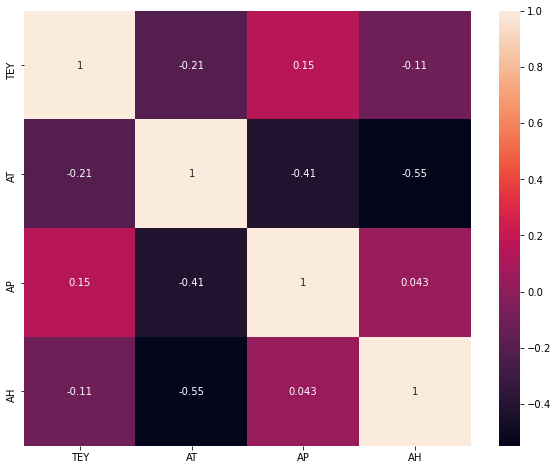

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(gas_t_corr,annot=True)
plt.show()

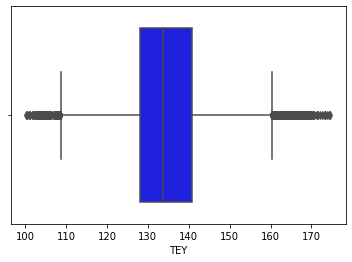

In [17]:
sns.boxplot(gas_turbines['TEY'], color = 'blue')
plt.show()

###  split into input (X) and output (y) variables

In [19]:
X=gas_turbines.iloc[:,1:5]
y=gas_turbines.iloc[:,0]

In [20]:
X

,AT,AP,AH
0,6.8594,1007.9,96.799
1,6.7850,1008.4,97.118
2,6.8977,1008.8,95.939
3,7.0569,1009.2,95.249
4,7.3978,1009.7,95.150
...,...,...,...
15034,9.0301,1005.6,98.460
15035,7.8879,1005.9,99.093
15036,7.2647,1006.3,99.496
15037,7.0060,1006.8,99.008


In [21]:
y

0        114.70
1        114.72
2        114.71
3        114.72
4        114.72
          ...  
15034    111.61
15035    111.78
15036    110.19
15037    110.74
15038    111.58
Name: TEY, Length: 15039, dtype: float64

In [22]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [23]:
# create model
model = Sequential()
model.add(Dense(12, input_dim=3,  kernel_initializer='uniform', activation='relu'))
model.add(Dense(8,  kernel_initializer='uniform', activation='relu'))
model.add(Dense(1,  kernel_initializer='uniform', activation='sigmoid'))

In [24]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
# Fit the model
history= model.fit(X, y,validation_split=0.33, epochs=150, batch_size=10)

Epoch 1/150
1008/1008 [==============================] - 3s 2ms/step - loss: -5714854.0000 - accuracy: 0.0000e+00 - val_loss: -22151962.0000 - val_accuracy: 0.0000e+00
Epoch 2/150
1008/1008 [==============================] - 2s 2ms/step - loss: -76865776.0000 - accuracy: 0.0000e+00 - val_loss: -150844384.0000 - val_accuracy: 0.0000e+00
Epoch 3/150
1008/1008 [==============================] - 2s 2ms/step - loss: -284282432.0000 - accuracy: 0.0000e+00 - val_loss: -432012704.0000 - val_accuracy: 0.0000e+00
Epoch 4/150
1008/1008 [==============================] - 1s 1ms/step - loss: -660786816.0000 - accuracy: 0.0000e+00 - val_loss: -889039808.0000 - val_accuracy: 0.0000e+00
Epoch 5/150
1008/1008 [==============================] - 2s 2ms/step - loss: -1227068800.0000 - accuracy: 0.0000e+00 - val_loss: -1540436224.0000 - val_accuracy: 0.0000e+00
Epoch 6/150
1008/1008 [==============================] - 2s 2ms/step - loss: -2002003968.0000 - accuracy: 0.0000e+00 - val_loss: -2404958720.0000 -

1008/1008 [==============================] - 2s 2ms/step - loss: -459835277312.0000 - accuracy: 0.0000e+00 - val_loss: -461900709888.0000 - val_accuracy: 0.0000e+00
Epoch 48/150
1008/1008 [==============================] - 2s 2ms/step - loss: -487257833472.0000 - accuracy: 0.0000e+00 - val_loss: -489169682432.0000 - val_accuracy: 0.0000e+00
Epoch 49/150
1008/1008 [==============================] - 2s 2ms/step - loss: -515728113664.0000 - accuracy: 0.0000e+00 - val_loss: -517460361216.0000 - val_accuracy: 0.0000e+00
Epoch 50/150
1008/1008 [==============================] - 2s 2ms/step - loss: -545263321088.0000 - accuracy: 0.0000e+00 - val_loss: -546811609088.0000 - val_accuracy: 0.0000e+00
Epoch 51/150
1008/1008 [==============================] - 2s 2ms/step - loss: -575874793472.0000 - accuracy: 0.0000e+00 - val_loss: -577215660032.0000 - val_accuracy: 0.0000e+00
Epoch 52/150
1008/1008 [==============================] - 2s 2ms/step - loss: -607602409472.0000 - accuracy: 0.0000e+00 - v

Epoch 93/150
1008/1008 [==============================] - 4s 4ms/step - loss: -3092197670912.0000 - accuracy: 0.0000e+00 - val_loss: -3063301537792.0000 - val_accuracy: 0.0000e+00
Epoch 94/150
1008/1008 [==============================] - 4s 4ms/step - loss: -3187325534208.0000 - accuracy: 0.0000e+00 - val_loss: -3157067563008.0000 - val_accuracy: 0.0000e+00
Epoch 95/150
1008/1008 [==============================] - 4s 4ms/step - loss: -3284347650048.0000 - accuracy: 0.0000e+00 - val_loss: -3252650246144.0000 - val_accuracy: 0.0000e+00
Epoch 96/150
1008/1008 [==============================] - 4s 4ms/step - loss: -3383288659968.0000 - accuracy: 0.0000e+00 - val_loss: -3350139502592.0000 - val_accuracy: 0.0000e+00
Epoch 97/150
1008/1008 [==============================] - 4s 4ms/step - loss: -3484181069824.0000 - accuracy: 0.0000e+00 - val_loss: -3449543983104.0000 - val_accuracy: 0.0000e+00
Epoch 98/150
1008/1008 [==============================] - 4s 4ms/step - loss: -3587047161856.0000 - 

1008/1008 [==============================] - 2s 2ms/step - loss: -9528071421952.0000 - accuracy: 0.0000e+00 - val_loss: -9393819090944.0000 - val_accuracy: 0.0000e+00
Epoch 139/150
1008/1008 [==============================] - 2s 2ms/step - loss: -9727595511808.0000 - accuracy: 0.0000e+00 - val_loss: -9589880782848.0000 - val_accuracy: 0.0000e+00
Epoch 140/150
1008/1008 [==============================] - 2s 2ms/step - loss: -9929886793728.0000 - accuracy: 0.0000e+00 - val_loss: -9788561817600.0000 - val_accuracy: 0.0000e+00
Epoch 141/150
1008/1008 [==============================] - 2s 2ms/step - loss: -10134889693184.0000 - accuracy: 0.0000e+00 - val_loss: -9989942935552.0000 - val_accuracy: 0.0000e+00
Epoch 142/150
1008/1008 [==============================] - 2s 2ms/step - loss: -10342667124736.0000 - accuracy: 0.0000e+00 - val_loss: -10194023088128.0000 - val_accuracy: 0.0000e+00
Epoch 143/150
1008/1008 [==============================] - 2s 2ms/step - loss: -10553255788544.0000 - accu

In [28]:
# evaluate the model
scores = model.evaluate(X, y)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

470/470 [==============================] - 0s 908us/step - loss: -12126306435072.0000 - accuracy: 0.0000e+00
accuracy: 0.00%


In [29]:
# list all data in history
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

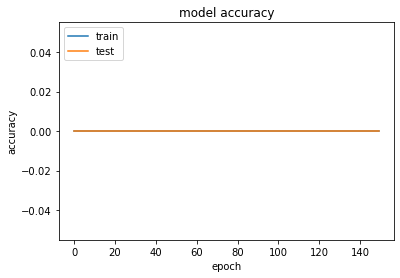

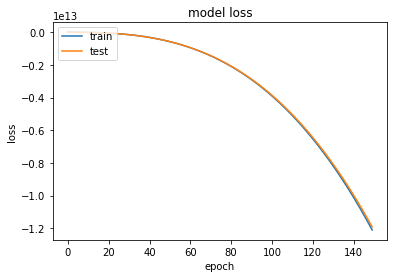

In [30]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Standardizing

In [31]:
a = StandardScaler()
a.fit(X)
X_standardized = a.transform(X)

In [32]:
pd.DataFrame(X_standardized).describe()

,0,1,2
count,1.503900e+04,1.503900e+04,1.503900e+04
mean,-2.320107e-16,-1.925280e-14,1.844983e-16
std,1.000033e+00,1.000033e+00,1.000033e+00
min,-2.276462e+00,-4.266288e+00,-3.536594e+00
25%,-8.392292e-01,-6.706510e-01,-6.796337e-01
50%,5.566605e-02,-6.227861e-02,2.277844e-01
75%,8.051309e-01,5.772924e-01,7.916582e-01
max,2.266234e+00,3.275970e+00,1.528011e+00


### Tuning of Hyperparameters :- Batch Size and Epochs

In [33]:
# Defining the model
def create_model():
    model = Sequential()
    model.add(Dense(12, input_dim=3, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))\
    
    adam=Adam(lr=0.01)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [34]:
# Create the model
model = KerasClassifier(build_fn = create_model,verbose = 0)
# Define the grid search parameters
batch_size = [10,20,40]
epochs = [10,50,100]
# Make a dictionary of the grid search parameters
param_grid = dict(batch_size = batch_size,epochs = epochs)
# Build and fit the GridSearchCV
grid = GridSearchCV(estimator = model,param_grid = param_grid,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_standardized,y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START batch_size=10, epochs=10....................................
[CV 1/5; 1/9] END .....batch_size=10, epochs=10;, score=0.000 total time=  17.8s
[CV 2/5; 1/9] START batch_size=10, epochs=10....................................
[CV 2/5; 1/9] END .....batch_size=10, epochs=10;, score=0.000 total time=  16.8s
[CV 3/5; 1/9] START batch_size=10, epochs=10....................................
[CV 3/5; 1/9] END .....batch_size=10, epochs=10;, score=0.000 total time=  15.2s
[CV 4/5; 1/9] START batch_size=10, epochs=10....................................
[CV 4/5; 1/9] END .....batch_size=10, epochs=10;, score=0.000 total time=  15.1s
[CV 5/5; 1/9] START batch_size=10, epochs=10....................................
[CV 5/5; 1/9] END .....batch_size=10, epochs=10;, score=0.000 total time=  15.6s
[CV 1/5; 2/9] START batch_size=10, epochs=50....................................
[CV 1/5; 2/9] END .....batch_size=10, epochs=50;,

In [35]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.0, using {'batch_size': 10, 'epochs': 10}
0.0,0.0 with: {'batch_size': 10, 'epochs': 10}
0.0,0.0 with: {'batch_size': 10, 'epochs': 50}
0.0,0.0 with: {'batch_size': 10, 'epochs': 100}
0.0,0.0 with: {'batch_size': 20, 'epochs': 10}
0.0,0.0 with: {'batch_size': 20, 'epochs': 50}
0.0,0.0 with: {'batch_size': 20, 'epochs': 100}
0.0,0.0 with: {'batch_size': 40, 'epochs': 10}
0.0,0.0 with: {'batch_size': 40, 'epochs': 50}
0.0,0.0 with: {'batch_size': 40, 'epochs': 100}


### Tuning of Hyperparameters:- Learning rate and Drop out rate

In [36]:
# Defining the model
def create_model(learning_rate,dropout_rate):
    model = Sequential()
    model.add(Dense(8,input_dim = 3,kernel_initializer = 'normal',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4,input_dim = 3,kernel_initializer = 'normal',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = learning_rate)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [37]:
# create the model
model = KerasClassifier(build_fn = create_model,verbose = 0,batch_size = 40,epochs = 10)

# Define the grid search parameters

learning_rate = [0.001,0.01,0.1]
dropout_rate = [0.0,0.1,0.2]

# Make a dictionary of the grid search parameters

param_grids = dict(learning_rate = learning_rate,dropout_rate = dropout_rate)

# Build and fit the GridSearchCV

grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_standardized,y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 1/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.000 total time=   3.6s
[CV 2/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 2/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.000 total time=   6.1s
[CV 3/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 3/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.000 total time=   4.9s
[CV 4/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 4/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.000 total time=   6.0s
[CV 5/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 5/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.000 total time=   3.7s
[CV 1/5; 2/9] START dropout_rate=0.0, learning_rate=0.01........................
[CV 1/5; 

In [38]:
#summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.0, using {'dropout_rate': 0.0, 'learning_rate': 0.001}
0.0,0.0 with: {'dropout_rate': 0.0, 'learning_rate': 0.001}
0.0,0.0 with: {'dropout_rate': 0.0, 'learning_rate': 0.01}
0.0,0.0 with: {'dropout_rate': 0.0, 'learning_rate': 0.1}
0.0,0.0 with: {'dropout_rate': 0.1, 'learning_rate': 0.001}
0.0,0.0 with: {'dropout_rate': 0.1, 'learning_rate': 0.01}
0.0,0.0 with: {'dropout_rate': 0.1, 'learning_rate': 0.1}
0.0,0.0 with: {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.0,0.0 with: {'dropout_rate': 0.2, 'learning_rate': 0.01}
0.0,0.0 with: {'dropout_rate': 0.2, 'learning_rate': 0.1}


### Tuning of Hyperparameters:- Activation Function and Kernel Initializer

In [39]:
def create_model(activation_function,init):
    model = Sequential()
    model.add(Dense(8,input_dim = 3,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.1))
    model.add(Dense(4,input_dim = 3,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.1))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [40]:
# Create the model
model = KerasClassifier(build_fn = create_model,verbose = 0,batch_size = 40,epochs = 10)

# Define the grid search parameters
activation_function = ['softmax','relu','tanh','linear']
init = ['uniform','normal','zero']

# Make a dictionary of the grid search parameters
param_grids = dict(activation_function = activation_function,init = init)

# Build and fit the GridSearchCV

grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_standardized,y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 1/5; 1/12] END activation_function=softmax, init=uniform;, score=0.000 total time=   5.4s
[CV 2/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 2/5; 1/12] END activation_function=softmax, init=uniform;, score=0.000 total time=   4.9s
[CV 3/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 3/5; 1/12] END activation_function=softmax, init=uniform;, score=0.000 total time=   5.0s
[CV 4/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 4/5; 1/12] END activation_function=softmax, init=uniform;, score=0.000 total time=   5.1s
[CV 5/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 5/5; 1/12] END activation_function=softmax, init=uniform;, score=0.000 total time=   5.7s
[CV 1/5; 2/12] START activation_function=softmax, init=normal...

[CV 3/5; 10/12] END activation_function=linear, init=uniform;, score=0.000 total time=   4.6s
[CV 4/5; 10/12] START activation_function=linear, init=uniform..................
[CV 4/5; 10/12] END activation_function=linear, init=uniform;, score=0.000 total time=   4.6s
[CV 5/5; 10/12] START activation_function=linear, init=uniform..................
[CV 5/5; 10/12] END activation_function=linear, init=uniform;, score=0.000 total time=   4.8s
[CV 1/5; 11/12] START activation_function=linear, init=normal...................
[CV 1/5; 11/12] END activation_function=linear, init=normal;, score=0.000 total time=   4.5s
[CV 2/5; 11/12] START activation_function=linear, init=normal...................
[CV 2/5; 11/12] END activation_function=linear, init=normal;, score=0.000 total time=   4.6s
[CV 3/5; 11/12] START activation_function=linear, init=normal...................
[CV 3/5; 11/12] END activation_function=linear, init=normal;, score=0.000 total time=   4.8s
[CV 4/5; 11/12] START activation_f

In [41]:
# Summarize the model
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.0, using {'activation_function': 'softmax', 'init': 'uniform'}
0.0,0.0 with: {'activation_function': 'softmax', 'init': 'uniform'}
0.0,0.0 with: {'activation_function': 'softmax', 'init': 'normal'}
0.0,0.0 with: {'activation_function': 'softmax', 'init': 'zero'}
0.0,0.0 with: {'activation_function': 'relu', 'init': 'uniform'}
0.0,0.0 with: {'activation_function': 'relu', 'init': 'normal'}
0.0,0.0 with: {'activation_function': 'relu', 'init': 'zero'}
0.0,0.0 with: {'activation_function': 'tanh', 'init': 'uniform'}
0.0,0.0 with: {'activation_function': 'tanh', 'init': 'normal'}
0.0,0.0 with: {'activation_function': 'tanh', 'init': 'zero'}
0.0,0.0 with: {'activation_function': 'linear', 'init': 'uniform'}
0.0,0.0 with: {'activation_function': 'linear', 'init': 'normal'}
0.0,0.0 with: {'activation_function': 'linear', 'init': 'zero'}


### Tuning of Hyperparameter :-Number of Neurons in activation layer

In [42]:
def create_model(neuron1,neuron2):
    model = Sequential()
    model.add(Dense(neuron1,input_dim = 3,kernel_initializer = 'uniform',activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = 'uniform',activation = 'tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [43]:
#Create the model
model = KerasClassifier(build_fn = create_model,verbose = 0,batch_size = 40,epochs = 10)

# Define the grid search parameters

neuron1 = [4,8,16]
neuron2 = [2,4,8]

# Make a dictionary of the grid search parameters

param_grids = dict(neuron1 = neuron1,neuron2 = neuron2)

# Build and fit the GridSearchCV

grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_standardized,y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 1/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.000 total time=   4.1s
[CV 2/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 2/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.000 total time=   4.8s
[CV 3/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 3/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.000 total time=   4.6s
[CV 4/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 4/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.000 total time=   4.2s
[CV 5/5; 1/9] START neuron1=4, neuron2=2........................................
[CV 5/5; 1/9] END .........neuron1=4, neuron2=2;, score=0.000 total time=   5.4s
[CV 1/5; 2/9] START neuron1=4, neuron2=4........................................
[CV 1/5; 2/9] END .........neuron1=4, neuron2=4;,

In [44]:
#Summarize the model
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.0, using {'neuron1': 4, 'neuron2': 2}
0.0,0.0 with: {'neuron1': 4, 'neuron2': 2}
0.0,0.0 with: {'neuron1': 4, 'neuron2': 4}
0.0,0.0 with: {'neuron1': 4, 'neuron2': 8}
0.0,0.0 with: {'neuron1': 8, 'neuron2': 2}
0.0,0.0 with: {'neuron1': 8, 'neuron2': 4}
0.0,0.0 with: {'neuron1': 8, 'neuron2': 8}
0.0,0.0 with: {'neuron1': 16, 'neuron2': 2}
0.0,0.0 with: {'neuron1': 16, 'neuron2': 4}
0.0,0.0 with: {'neuron1': 16, 'neuron2': 8}


### Training model with optimum values of Hyperparameters

In [45]:
# Defining the model

def create_model():
    model = Sequential()
    model.add(Dense(16,input_dim = 3,kernel_initializer = 'normal',activation = 'linear'))
    model.add(Dropout(0.1))
    model.add(Dense(8,input_dim = 3,kernel_initializer = 'normal',activation = 'linear'))
    model.add(Dropout(0.1))
    model.add(Dense(1,activation = 'linear'))
    
    adam = Adam(lr = 0.01) #sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [46]:
# Create the model
model = KerasClassifier(build_fn = create_model,verbose = 0,batch_size = 40,epochs = 100)

# Fitting the model

model.fit(X_standardized,y)

# Predicting using trained model

y_predict = model.predict(X_standardized)

# Printing the metrics
print(accuracy_score(y_predict.round(),y.round()))

0.00013298756566261055
